## Project Description

```
Company XYZ sells a software for $39. Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66% of the users have seen the old price ($39), while a random sample of 33% users a higher price ($59).

The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users.

Especially, you were asked the following questions:

1. Should the company sell its software for $39 or $59?

2. The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?

3. The VP of Product feels that the test has been running for too long and they should have been able to get statistically significant results in a shorter time. Do you agree with this? After how many days you would have stopped the test? Please, explain why.
```

---

## Load data

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [86]:
test = pd.read_csv('test_results.csv')
user = pd.read_csv('user_table.csv')

In [3]:
test.head(3)

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0


In [4]:
user.head(3)

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39


In [6]:
print('number of users in test table: ',test.user_id.nunique())
print('number of users in user table: ',user.user_id.nunique())
print('diff users between two tables: ',test.user_id.nunique()-user.user_id.nunique())

number of users in test table:  316800
number of users in user table:  275616
diff users between two tables:  41184


In [87]:
#merge two tables
data = pd.merge(test, user, how='left',on='user_id')
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [88]:
# check the users assignments
data.groupby(['test','price']).agg({'user_id':'count','converted':'mean'})

user_id  converted
test price                    
0    39      202517   0.019900
     59         210   0.023810
1    39         155   0.006452
     59      113918   0.015555

* <font size=3>there are some mix users between test and control groups, luckily it's a samll proportion of users, so let's filter it out.

In [89]:
# filter out the wrong assigned users
df = data.drop(data[(data['test']==0)&(data['price']==59)].index, axis = 0)
df = df.drop(df[(df['test']==1)&(df['price']==39)].index, axis=0)
df.groupby(['test','price']).agg({'user_id':'count','converted':'mean'})

,,user_id,converted
test,price,,
0,39,202517,0.019900
1,59,113918,0.015555


In [23]:
import cufflinks as cf
cf.go_offline()

In [24]:
# check missing values
df.count().iplot(kind='barh')

---


<font size=4>Question 1: Should the company sell its software for 39 or 59?


* the metric we define: the average revenue generated per user

<font size=3>1.1 Sanity check

* Users distribution in control and test groups should be similar

In [221]:
# check whether users are splitted randomly in different sources
t_source = df.groupby('test').source.value_counts().unstack()
display(t_source)

from scipy.stats import chi2_contingency, chi2
stats, pvalue, dof, ex_talbe = chi2_contingency(t_source, correction=False)
critical = chi2.ppf(0.95, dof)
if abs(stats) >= critical:
    print('reject H0: dependent!\n',
          'Users are not splitted randomly into test and control groups.')
else:
    print('fail to reject H0: independent!\n',
          'Users are randomly assigned to test and control groups.')

source,ads-bing,ads-google,ads-yahoo,ads_facebook,ads_other,direct_traffic,friend_referral,seo-bing,seo-google,seo-other,seo-yahoo,seo_facebook
test,,,,,,,,,,,,
0,14584,37845,4812,34074,19256,38712,13121,1329,15088,5879,4356,13461
1,8247,21497,2759,19281,10570,21560,7557,815,8060,3365,2485,7722


reject H0: dependent!
 Users are not splitted randomly into test and control groups.


In [224]:
# check whether users are splitted randomly in different device
t_device = df.groupby('test').device.value_counts().unstack()
display(t_device)

stats, p, dof, ex = chi2_contingency(t_device, correction=False)
critical = chi2.ppf(0.95, dof)
if abs(stats) >= critical:
    print('reject H0: dependent!\n',
          'Users are not splitted randomly into test and control groups.')
else:
    print('fail to reject H0: independent!\n',
          'Users are randomly assigned to test and control groups.')

device,mobile,web
test,,
0,120369,82148
1,65898,48020


reject H0: dependent!
 Users are not splitted randomly into test and control groups.


In [225]:
# check whether users are splitted randomly in different operative system
t_system = df.groupby('test').operative_system.value_counts().unstack()
display(t_system)

stats, p, dof, ex = chi2_contingency(t_system, correction=False)
critical = chi2.ppf(0.95, dof)
if abs(stats) >= critical:
    print('reject H0: dependent!\n',
          'Users are not splitted randomly into test and control groups.')
else:
    print('fail to reject H0: independent!\n',
          'Users are randomly assigned to test and control groups.')

operative_system,android,iOS,linux,mac,other,windows
test,,,,,,
0,48177,61793,2204,16345,10481,63517
1,26693,33560,1926,8710,5696,37333


reject H0: dependent!
 Users are not splitted randomly into test and control groups.


<font size=3>1.2 effect test

In [90]:
# create revenue, date column
df['revenue'] = df['price'] * df['converted']
df['date'] = df['timestamp'].apply(lambda x: x[:10])

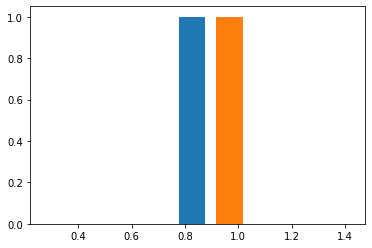

In [158]:
plt.hist(df[df['test']==0].revenue.mean())
plt.hist(df[df['test']==1].revenue.mean())
plt.show()

In [160]:
df.groupby('test').revenue.mean().to_frame('avg. revenue')

,avg. revenue
test,
0,0.776083
1,0.917748


In [161]:
## do t-test for average revenue metric
from scipy.stats import ttest_ind
stat, pvalue = ttest_ind(df[df['test']==0]['revenue'],
                        df[df['test']==1]['revenue'], equal_var=False)
pvalue/2

5.486288656210391e-09

<font size=3> 1.3 double check with sign test

In [211]:
## let's double check with sign test
t_sign = df.groupby(['date','test']).revenue.mean().unstack()

In [212]:
## sign test
from statsmodels.stats.descriptivestats import sign_test
m, p = sign_test(t_sign[0],t_sign[1])
print('p_value:',p)

p_value: 0.0015165131944572222


<font size=3> pvalue < 0.05, so we reject the null hypothesis. There is a statistically difference between test and control groups.
                            
<font size=3>Which means the average revenue has increased significant when set the price at $59.  

<font size=3>But, we can't decide to increase the price based on that, because the test and control groups are not assigned randomly, so we need to fix the randomization issue first.

---

<font size = 4>Question 2: User behaviors - what else can increase conversion rate?

* <font size=3> 2.1 check conversion rate's statistical significance

In [214]:
table = df.groupby(['test','converted']).size().unstack()
table

converted,0,1
test,,
0,198487,4030
1,112146,1772


In [215]:
## do chi-squared test for conversion rate metric
stats, pvalue, dof, ex_talbe = chi2_contingency(table, correction=False)
prob = 0.95
critical = chi2.ppf(0.95, dof)
if abs(stats) >= critical:
    print('reject H0: dependent!\n',
          'There are truly difference in conversion rate between control and test groups.')
else:
    print('fail to reject H0: independent!\n',
          'There are no difference in conversion rate between control and test group.')

reject H0: dependent!
 There are truly difference in conversion rate between control and test groups.


<font size=3> Above result shows that increasing the price causes the drops of conversion rate. So in order to increase the conversion rate, it's better to lower down the price.

* <font size=3> 2.2 check conversion rate in different segments

In [244]:
control = df[df['test']==0]
test = df[df['test'] ==1]

In [245]:
control.head(2)

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,revenue,date
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86,0,2015-05-08
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24,0,2015-05-10


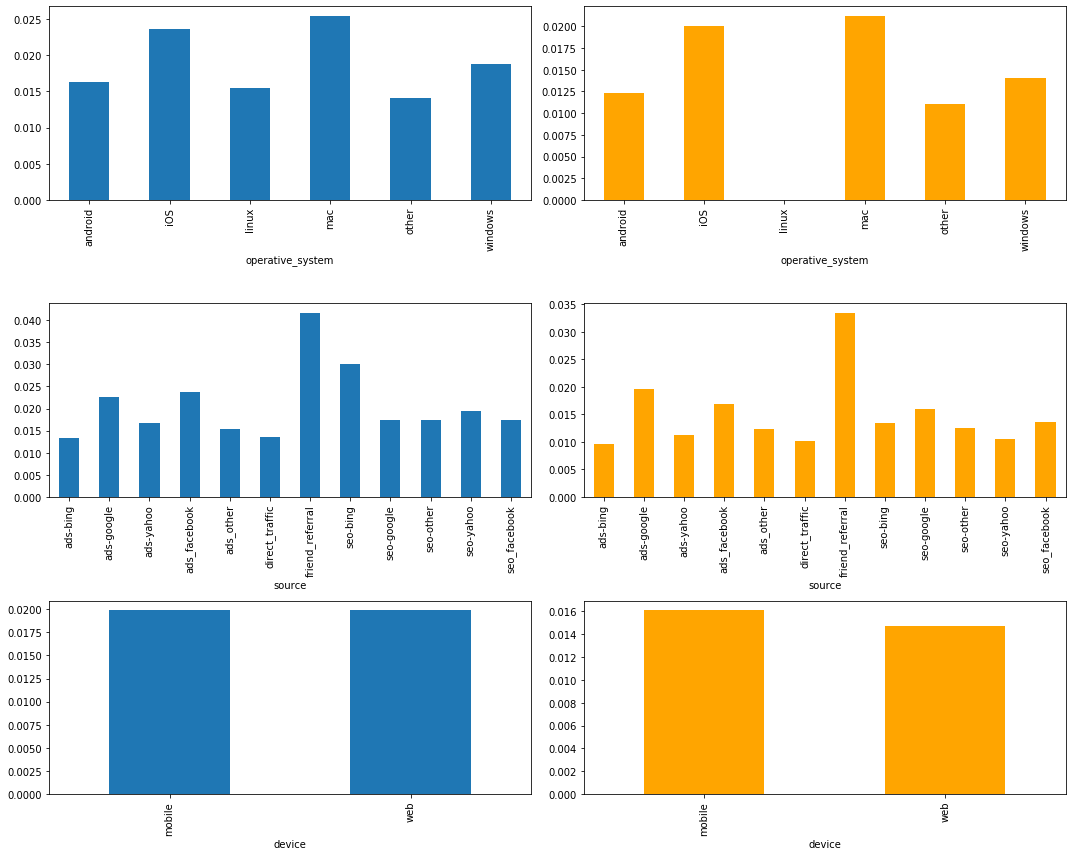

In [267]:
fig, ax = plt.subplots(3,2,figsize=(15,12))
control.groupby('operative_system').converted.mean().plot(kind='bar',ax=ax[0][0])
test.groupby('operative_system').converted.mean().plot(kind = 'bar',ax=ax[0][1],color='orange')
control.groupby('source').converted.mean().plot(kind='bar',ax=ax[1][0])
test.groupby('source').converted.mean().plot(kind = 'bar',ax=ax[1][1],color='orange')
control.groupby('device').converted.mean().plot(kind='bar',ax=ax[2][0])
test.groupby('device').converted.mean().plot(kind = 'bar',ax=ax[2][1],color='orange')

plt.tight_layout()

### From the above charts, we can see that:

- For operative system:
  - there seems to be something wrong with Linux system in test group, we may need to check it with engineers

- For source:
  - the friend referral source has much higher conversion rate than others.
  - the conversion rate in seo-bing drops a lot in test group compared to control group. We may need to dig deeper to find out the reason.
  
- For device:
  - there is no much difference in conversion rate between mobile and web
  - the conversion rate drops a little in test group compared to control group, and we may need to figure it out what the reason caused the drop.

---

<font size=4> Question 3: How to decide the duration of the experiment?

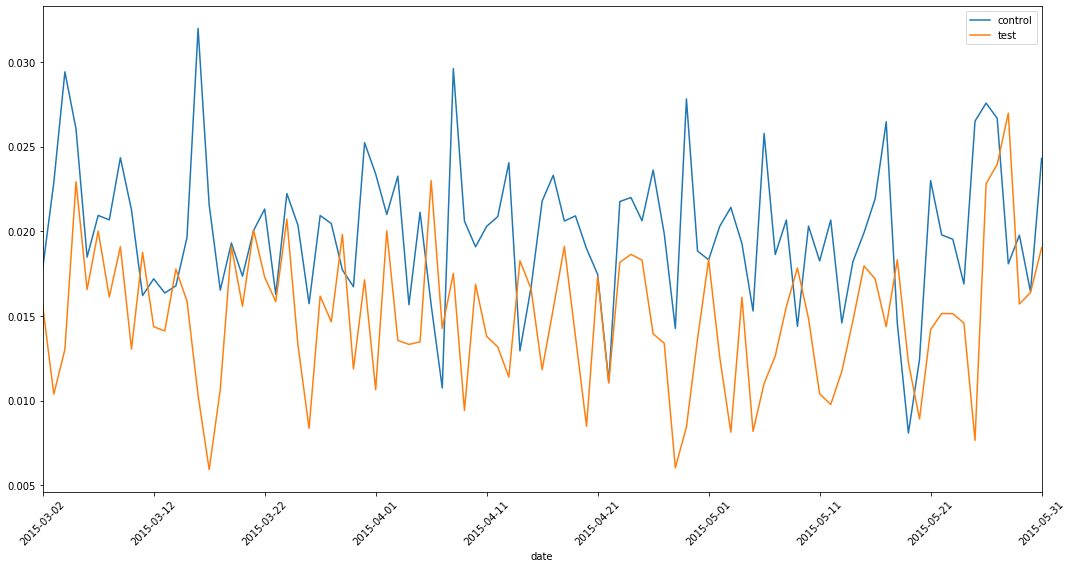

In [286]:
plt.figure(figsize=(15,8))
df[df['test']==0].groupby('date').converted.mean().plot()
df[df['test']==1].groupby('date').converted.mean().plot()

plt.xticks(rotation=45)
plt.legend(['control','test'])
plt.tight_layout()

<font size=4>I will not end the experiment in a shorter time, because of the following reasons:

- we need to run longer to cover users behavior patterns in different time periods.

- we need to run long to get enough sample size, so that we can get a statistical result with a high power